# Disclaimer
When making this notebook I used the ipympl backend in order to generate the
plots; as opposed to the default "inline" backend. Unfortunately ipympl does
not support image embedding, and as such I had to create a workaround which
is why there are calls to the "save_and_show" function. Any changes to the code
will still be reflected in the plots in real time, it just may take a bit longer
to run as the plot first has to be exported as an image, then reloaded back into
the notebook.

### Questions

1. When have there been spikes in UFO activity?
2. Is there a relationship between the time of year and the amount of UFO sightings?
3. Do more UFO sightings happen during day time or night time?
4. How has the amount of UFO sightings per year changed over time?
5. What state has the most UFO reports per capita?

### Imports

In [1]:
# Imports

import ephem
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import patches as ptchs
from matplotlib import rc
import numpy as np
import pandas as pd
import re
from zoneinfo import ZoneInfo

%matplotlib ipympl

In [2]:
# This is for the github repo. See disclaimer for explanation.
plt.ioff()

def save_and_show(path, fig):
    fig.savefig(path)
    display.display(display.Image(path))

In [3]:
# Useful variables

month_names = ['January', 
               'February', 
               'March', 
               'April',
               'May', 
               'June', 
               'July', 
               'August', 
               'September', 
               'October', 
               'November', 
               'December']

In [4]:
# Data imports

aliens = pd.read_csv('Datasets/nuforc_events.csv')
state_populations = pd.read_csv('Datasets/state_data.csv')\
                      .set_index('abbreviation')\
                      [['state_name', 'population']]
uscities = pd.read_csv('Datasets/uscities.csv')\
             [['city', 'state_id', 'lat', 'lng', 'timezone', 'population']]

In [5]:
aliens.head(2)

,event_time,event_date,year,month,day,hour,minute,city,state,shape,duration,summary,event_url
0,2017-04-20T14:15:00Z,2017-04-20,2017.0,4.0,20.0,14.0,15.0,Palmyra,NJ,Other,5 minutes,I observed an aircraft that seemed to look odd.,http://www.nuforc.org/webreports/133/S133726.html
1,2017-04-20T04:56:00Z,2017-04-20,2017.0,4.0,20.0,4.0,56.0,Bridgeview,IL,Light,20 seconds,"Bridgeview, IL, blue light. ((anonymous report))",http://www.nuforc.org/webreports/133/S133720.html


In [6]:
state_populations.head(2)

,state_name,population
abbreviation,,
AL,Alabama,"4,863,525"
AK,Alaska,"741,456"


In [7]:
uscities.head(2)

,city,state_id,lat,lng,timezone,population
0,New York,NY,40.6943,-73.9249,America/New_York,18713220
1,Los Angeles,CA,34.1139,-118.4068,America/Los_Angeles,12750807


### Data Cleaning

#### General Cleanup

In [8]:
# Convert timestamps to date time objects
aliens = aliens.dropna(subset = ['event_time'])
aliens['event_time'] = pd.to_datetime(aliens['event_time'], format = '%Y-%m-%dT%H:%M:%SZ', errors = 'coerce')
aliens = aliens.dropna(subset = ['event_time'])
# There were about 20 invalid states in the set that needed to be removed.
valid_state_names = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL',
                     'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA',
                     'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE',
                     'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK',
                     'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT',
                     'VA', 'WA', 'WV', 'WI', 'WY', 'DC', 'PR', 'GU']
# Remove all invalid states and convert all valid states to uppercase.
aliens = aliens.dropna(subset = ['city', 'state'], how = 'any')
aliens = aliens[aliens.state.isin(valid_state_names)].copy()
aliens.state = list(map(lambda x : x.upper(), aliens.state))
# Make every borough of New York count as a single city.
def deborough(city):
    """Accepts a string. If that string contains 'new york city', returns
    'NYC', otherwise returns the original string.
    
    ----------------------------------------------------------------------------
    
    args:
        city - string
        
    returns:
        string which is either the city argument or 'NYC' depending on what the
        city argument contains.
    """
    if 'new york city' in city.lower():
        return 'NYC'
    else:
        return city
aliens.city = list(map(deborough, aliens.city))

#### Question 3 Cleaning/Wrangling
Do more UFO sightings happen during day time or night time?

In [9]:
def create_observers(lat_list, 
                     lon_list, 
                     in_degrees = True):
    """Takes a list of latitudes and longitudes and yields a list of pyephem
    observers containing those coordinates.
    
    ----------------------------------------------------------------------------
    
    args:
        lat_list - iterable of latitudes
        lon_list - iterable of longitudes
        
    optional args:
        in_degrees - boolean which if true denotes that the coordinates provided
        are in degrees
            defaults to True
            
    returns:
        iterable of pyephem observers
    """
    # Ephem takes lat/lon measures in radians, so degree coordinates need to be
    # converted.
    if in_degrees:
        lat_list = np.radians(lat_list)
        lon_list = np.radians(lon_list)
    
    for lat, lon in zip(lat_list, lon_list):
        new_observer = ephem.Observer()
        
        new_observer.lat = lat
        new_observer.lon = lon
    
        yield new_observer
# Create ephem observers for each city from lat/long pairs.
uscities['observer'] = list(create_observers(uscities['lat'], 
                                             uscities['lng']))
# Create combination of city and state columns to be used as a key for merging
# the uscities and aliens datasets.
uscities['city_state'] = uscities['city'] + uscities['state_id']
aliens['city_state'] = aliens['city'] + aliens['state']
# Subset the cities data to make the final result less verbose.
observers = uscities[['observer', 'city_state', 'timezone']].copy()

aliens = aliens.merge(observers,
                      left_on = 'city_state',
                      right_on = 'city_state',
                      how = 'left')

In [10]:
aliens[['event_time', 'observer', 'timezone']].head(3)

,event_time,observer,timezone
0,2017-04-20 14:15:00,<ephem.Observer date='2021/6/22 20:51:27' epoc...,America/New_York
1,2017-04-20 04:56:00,<ephem.Observer date='2021/6/22 20:51:27' epoc...,America/Chicago
2,2017-04-19 23:55:00,<ephem.Observer date='2021/6/22 20:51:27' epoc...,America/Chicago


In [11]:
# Get the highest population city for each state.
uscities['state_max_pop'] = uscities[['state_id', 'population']]\
                                    .groupby('state_id')\
                                    ['population']\
                                    .transform(max)
most_pop_cities = uscities[uscities.state_max_pop == uscities.population].copy()

In [12]:
most_pop_cities.head(3)

,city,state_id,lat,lng,timezone,population,observer,city_state,state_max_pop
0,New York,NY,40.6943,-73.9249,America/New_York,18713220,<ephem.Observer date='2021/6/22 20:51:27' epoc...,New YorkNY,18713220
1,Los Angeles,CA,34.1139,-118.4068,America/Los_Angeles,12750807,<ephem.Observer date='2021/6/22 20:51:27' epoc...,Los AngelesCA,12750807
2,Chicago,IL,41.8373,-87.6862,America/Chicago,8604203,<ephem.Observer date='2021/6/22 20:51:27' epoc...,ChicagoIL,8604203


In [13]:
# Grab the observer of the most populated city for the state provided.
def substitute_default(column,
                       key,
                       data,
                       default_column = None,
                       default_key = None,
                       defaults = pd.DataFrame()):
    """Replace nulls im column with defaults based on a key.
    
    ----------------------------------------------------------------------------
    
    args:
        column - name of column with nulls you would like to replace
        key - key which matches null values with their replacements
        data - pandas dataframe which contains the column and key specified
        
    optional args:
        default_col - name of column with replacements for null values
            if no vlaue is provided this equals "column"
        default_key - key which matches replacements to null values
            if no value is provided this equals "key"
        defaults - pandas dataframe containing the replacements for null values
        and the key need to match them
            if no value is provided this equals "data"
            
    returns:
        iterable equivalent to the original series but with nulls replaced by
        specified defaults
    """
    if default_column == None:
        default_column = column
    if default_key == None:
        default_key = key
    if defaults.shape[0] == 0:
        defaults = data
    for current_key, value in zip(data[key], data[column]):
        if pd.isnull(value):
            # Get the row from defaults where the value of the key column
            # corresponds to the value of the key column for the current row.
            query = '{} == "{}"'.format(default_key, current_key)
            default = defaults.query(query)
            # Yield the default that coresponds to the value of the key for the
            # current row.
            yield default.iloc[0][default_column]
        else:
            yield value
# For every sighting that still doesn't have an observer, substitute that null
# value with the observer for the most populated city within the state that the
# sighting took place in.
aliens['observer'] = list(substitute_default(column = 'observer',
                                             key = 'state',
                                             data = aliens,
                                             default_key = 'state_id',
                                             defaults = most_pop_cities))
aliens['timezone'] = list(substitute_default(column = 'timezone',
                                             key = 'state',
                                             data = aliens,
                                             default_key = 'state_id',
                                             defaults = most_pop_cities))

In [14]:
aliens[['event_time', 'observer', 'timezone']].head(3)

,event_time,observer,timezone
0,2017-04-20 14:15:00,<ephem.Observer date='2021/6/22 20:51:27' epoc...,America/New_York
1,2017-04-20 04:56:00,<ephem.Observer date='2021/6/22 20:51:27' epoc...,America/Chicago
2,2017-04-19 23:55:00,<ephem.Observer date='2021/6/22 20:51:27' epoc...,America/Chicago


In [15]:
# Timestamps are submitted in the local time of whatever location they happen in
# while ephem takes timestamps only in UTC.
def convert_to_utc(timestamps, timezones):
    """Converts timestamps to UTC time using corresponding timezones as a
    reference.
    
    ----------------------------------------------------------------------------
    
    args:
        timestamps - iterable of datetime objects
        timezones - iterable of timezone names which correspond to the timezone
        the timestamp was originally made in
        
    returns:
        iterable of the orginal timestamps utc equivalents"""
    for ts, tz in zip(timestamps, timezones):
        ts = ts.replace(tzinfo = ZoneInfo(tz))
        ts = ts.astimezone('UTC')
        yield ts
aliens['event_time_utc'] = list(convert_to_utc(aliens.event_time, 
                                               aliens.timezone))
# Change the timestamp in each observer to the time of its sighting.
def alter_time(timestamp, observer):
    """Changes the timestamp in the observer to the timestamp provided.
    
    ----------------------------------------------------------------------------
    
    args:
        timestamp - timestamp to which the date property of the observer should
        be changed
        observer - observer which should have its timestamp changed
        
    returns:
        observer with timestamp assigned to date property"""
    # Reformat the timestamp to be compatible with the observer.
    timestamp = str(timestamp)
    timestamp = re.sub('-', '/', timestamp)
    timestamp = ephem.Date(timestamp)
    # Had to make a new observer to get around a bug where only some of the
    # observers wouldn't accept the new timestamp no matter what.
    new_obs = ephem.Observer()
    
    new_obs.lat = observer.lat
    new_obs.lon = observer.lon
    new_obs.date = timestamp
    
    return new_obs
# Alter the time of each observer to the time of their respective sightings.
aliens.observer = list(map(alter_time, aliens.event_time_utc, aliens.observer))
### Determine day/night for each sighting.
def day_or_night(observer):
    """Determines whether the sun was up or down using the provided observer.
    
    ----------------------------------------------------------------------------
    
    args:
        observer - a pyephem observer object
        
    returns:
        "day" or "night" depending on the altitude of the sun according to the
        observer
    """
    alt = str(ephem.Sun(observer).alt)
    if alt[0] != '-':
        return 'day'
    else:
        return 'night'
# Add a column that denotes whether the sun was up or down during the sighting.
aliens['day_night'] = list(map(day_or_night, aliens['observer']))

In [16]:
aliens[['event_time', 'event_time_utc', 'observer', 'timezone']].head(3)

,event_time,event_time_utc,observer,timezone
0,2017-04-20 14:15:00,2017-04-20 18:15:00+00:00,<ephem.Observer date='2017/4/20 18:15:00' epoc...,America/New_York
1,2017-04-20 04:56:00,2017-04-20 09:56:00+00:00,<ephem.Observer date='2017/4/20 09:56:00' epoc...,America/Chicago
2,2017-04-19 23:55:00,2017-04-20 04:55:00+00:00,<ephem.Observer date='2017/4/20 04:55:00' epoc...,America/Chicago


In [17]:
# Crate a column that counts the reports for each date.
aliens['reports_this_date'] = aliens[['event_date', 'summary']]\
                                    .groupby('event_date')\
                                    .transform('count')

In [18]:
aliens[['event_date', 'reports_this_date']].head(7)

,event_date,reports_this_date
0,2017-04-20,2
1,2017-04-20,2
2,2017-04-19,10
3,2017-04-19,10
4,2017-04-19,10
5,2017-04-19,10
6,2017-04-19,10


#### Question 5 Cleaning/Wrangling
What state has the most UFO reports per capita?

In [19]:
# Before: 1,234,567 string
# After:  1234567   int
state_populations.population = list(map(lambda x : int(re.sub(',', '', x)),
                                        state_populations.population))
# Get the amount of reports from each state.
state_reports = aliens[['state', 'summary']]\
                       .rename(columns = {'summary':'reports'})\
                       .groupby('state')\
                       .count()
# Join the population data to the report data.
states = state_reports.join(state_populations)
# Find the most commonly reporting city per state.
most_common_cities_per_state = aliens[['state', 'city']]\
                               .groupby('state')\
                               .agg(pd.Series.mode)
# Calculate the reports per capita for every state.
states['reports_per_capita'] = states.reports/states.population
states = states.sort_values('reports_per_capita')

In [20]:
states.head()

,reports,state_name,population,reports_per_capita
state,,,,
PR,36,Puerto Rico,3406672,0.000011
TX,4639,Texas,27914410,0.000166
DC,124,District of Columbia,685815,0.000181
LA,858,Louisiana,4678135,0.000183
GA,1923,Georgia,10301890,0.000187


#### Results

In [21]:
aliens.head(5)

,event_time,event_date,year,month,day,hour,minute,city,state,shape,duration,summary,event_url,city_state,observer,timezone,event_time_utc,day_night,reports_this_date
0,2017-04-20 14:15:00,2017-04-20,2017.0,4.0,20.0,14.0,15.0,Palmyra,NJ,Other,5 minutes,I observed an aircraft that seemed to look odd.,http://www.nuforc.org/webreports/133/S133726.html,PalmyraNJ,<ephem.Observer date='2017/4/20 18:15:00' epoc...,America/New_York,2017-04-20 18:15:00+00:00,day,2
1,2017-04-20 04:56:00,2017-04-20,2017.0,4.0,20.0,4.0,56.0,Bridgeview,IL,Light,20 seconds,"Bridgeview, IL, blue light. ((anonymous report))",http://www.nuforc.org/webreports/133/S133720.html,BridgeviewIL,<ephem.Observer date='2017/4/20 09:56:00' epoc...,America/Chicago,2017-04-20 09:56:00+00:00,night,2
2,2017-04-19 23:55:00,2017-04-19,2017.0,4.0,19.0,23.0,55.0,Newton,AL,Triangle,5 seconds,Silent triangle UFO.,http://www.nuforc.org/webreports/133/S133724.html,NewtonAL,<ephem.Observer date='2017/4/20 04:55:00' epoc...,America/Chicago,2017-04-20 04:55:00+00:00,night,10
3,2017-04-19 23:50:00,2017-04-19,2017.0,4.0,19.0,23.0,50.0,Newton,AL,Triangle,5-6 minutes,My friend and I stepped outside hoping to catc...,http://www.nuforc.org/webreports/133/S133723.html,NewtonAL,<ephem.Observer date='2017/4/20 04:50:00' epoc...,America/Chicago,2017-04-20 04:50:00+00:00,night,10
4,2017-04-19 23:29:00,2017-04-19,2017.0,4.0,19.0,23.0,29.0,Denver,CO,Light,1 hour,Moved slow but made quick turns staying and ci...,http://www.nuforc.org/webreports/133/S133721.html,DenverCO,<ephem.Observer date='2017/4/20 05:29:00' epoc...,America/Denver,2017-04-20 05:29:00+00:00,night,10


### Question 1.
When have there been spikes in UFO activity?

#### Independence Day Spike

In [22]:
# Data Wrangling
july_means = aliens.query('month == 7')\
                   [['day', 'reports_this_date']]\
                   .groupby('day')\
                   .mean()

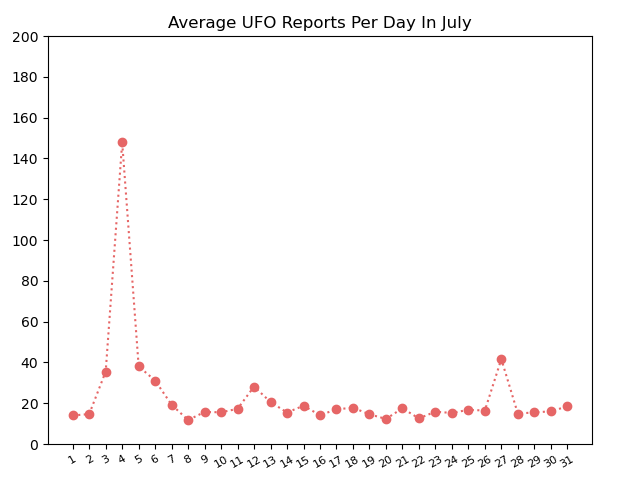

In [23]:
fig_1 = plt.figure()
ax = fig_1.add_axes([0.075, 0.075, 0.85, 0.85])

ax.plot(july_means.index,
        july_means.reports_this_date,
        ls = ':',
        color = (0.9, 0.4, 0.4),
        marker = 'o')

# Ticks
ax.set_xticks(np.arange(1, 32))
ax.set_xticklabels(np.arange(1, 32))
ax.set_yticks(np.arange(0, 201, 20))
ax.tick_params(rotation = 30, 
               axis = 'x',
               labelsize = 8)

# Labelling
ax.set_title('Average UFO Reports Per Day In July');

#-------------------------------------------------------------------------------
save_and_show('Plots/1 - July Spike.png', fig_1)

#### Rocket Launch Spike

In [24]:
# Data Wrangling
november_2015_counts = aliens.query('year == 2015 & month == 11')\
                             .groupby('day')\
                             .count()

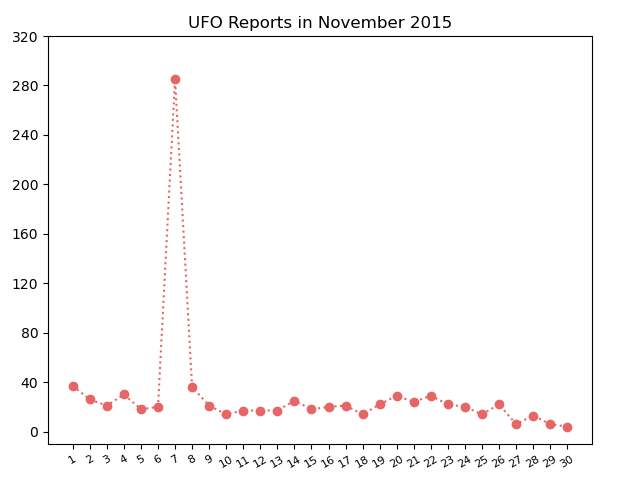

In [25]:
fig_2 = plt.figure()
ax = fig_2.add_axes([0.075, 0.075, 0.85, 0.85])
ax.plot(november_2015_counts.index,
        november_2015_counts.summary,
        ls = ':',
        color = (0.9, 0.4, 0.4),
        marker = 'o')

# Ticks
ax.set_xticks(np.arange(1, 31))
ax.set_xticklabels(np.arange(1, 31))
ax.set_yticks(np.arange(0, 321, 40))
ax.tick_params(rotation = 30, 
               axis = 'x',
               labelsize = 8)

# Labelling
ax.set_title('UFO Reports in November 2015');

#-------------------------------------------------------------------------------
save_and_show('Plots/2 - November 2015 Spike.png', fig_2)

In [26]:
aliens.query('event_date == "2015-11-07"').event_url

7238    http://www.nuforc.org/webreports/126/S126938.html
7239    http://www.nuforc.org/webreports/123/S123818.html
7240    http://www.nuforc.org/webreports/123/S123843.html
7241    http://www.nuforc.org/webreports/123/S123807.html
7242    http://www.nuforc.org/webreports/123/S123572.html
                              ...                        
7518    http://www.nuforc.org/webreports/123/S123877.html
7519    http://www.nuforc.org/webreports/123/S123869.html
7520    http://www.nuforc.org/webreports/123/S123544.html
7521    http://www.nuforc.org/webreports/123/S123537.html
7522    http://www.nuforc.org/webreports/123/S123541.html
Name: event_url, Length: 285, dtype: object

### Question 2.
Is there a relationship between the time of year and the amount of UFO sightings?

#### UFO Reports Per Month Trend

In [27]:
# Data Wrangling
aliens_no_4th = aliens.query('(day != 4 | month != 7)')\
                      .copy()
# This will give each entry a column containing the total amount of reports
# for that entry's year.
aliens_no_4th['reports_this_year'] = aliens_no_4th[['year', 'summary']]\
                                                  .groupby('year')\
                                                  .transform('count')
# This will give each entry a column containing the total amount of reports
# for that entry's month.
aliens_no_4th['reports_this_month'] = aliens_no_4th[['year', 'month', 'summary']]\
                                                   .groupby(['year', 'month'])\
                                                   .transform('count')

aliens_no_4th['month_year_ratio'] = aliens_no_4th.reports_this_month/aliens_no_4th.reports_this_year
# Create a grouping with minimum and maximum month/year ratios for each month.
ratio_group = aliens_no_4th.query('year >= 2000 & year <= 2020')\
              [['month', 'month_year_ratio']]\
              .groupby('month')\
              .month_year_ratio\
              .agg([pd.Series.min, pd.Series.max])

In [28]:
# The matplotlib func animation takes 2 things: a function which returns a list
# of artists, and a list of frames each of which are used as an arugment for the
# function. I set this up so that the function would accept a dictionary.

# The only consistent property within the dicts is the phase property, which is
# used to determine which action the function should take. Everything else is
# specific to whatever phase the frame is a part of.

frames = []

# These are some properties which allow for tweaking of the fade times.
indv_fade_frames = 60
minmax_fade_frames = 30

# Buffer adds empty frames in whatever quantity is specified. This allows for
# delays between state changes so as to better pace the animation.
def buffer(count):
    """Adds buffer frames to the frames list.
    
    ----------------------------------------------------------------------------
    
    args:
        count - integer denoting the amount of buffer frames to add to the frame
        list.
        
    returns:
        None
    """
    for i in np.arange(count):
        frame = {}
        frame['phase'] = -1
        frames.append(frame)

# Make a frame for each year's month_year ratio line.
for year in np.arange(2000, 2021, 1):
    # Get the most common month/year ratio for each month in the current year.
    ratios_by_month = aliens_no_4th.query('year == {}'.format(year))\
                                    [['month', 'month_year_ratio']]\
                                    .groupby('month')\
                                    .agg(pd.Series.mode)

    frame = {}
    frame['phase'] = 1
    # This is used for the title changes.
    frame['year'] = year
    frame['positions'] = ratios_by_month
    frames.append(frame)
    # Add empty frames between this frame and the next.
    buffer(5)
    
# Add one phase 2 frame to plot the initially invisible minimun and maximum
# lines.
frame = {}
frame['phase'] = 2
frames.append(frame)

# Add frames to instruct the fade out of the individual ratio lines.
for i in np.arange(indv_fade_frames):
    frame = {}
    frame['phase'] = 3
    # The "stage" refers to how far into the fade the function is. The "stages"
    # is there as context for the "stage". Using these, the function determines
    # where inbetween the start and end colors the lines should be.
    frame['stage'] = i
    frame['stages'] = indv_fade_frames
    frames.append(frame)

# Add frames to instruct the fade in of the minimum and maximum ratio lines.
for i in np.arange(minmax_fade_frames):
    frame = {}
    frame['phase'] = 4
    # The "stage" refers to how far into the fade the function is. The "stages"
    # is there as context for the "stage". Using these, the function determines
    # where inbetween the start and end colors the lines should be.
    frame['stage'] = i
    frame['stages'] = minmax_fade_frames
    frames.append(frame)
    
# Add empty frames at the end so that the animation doesn't immediately restart.
buffer(120)

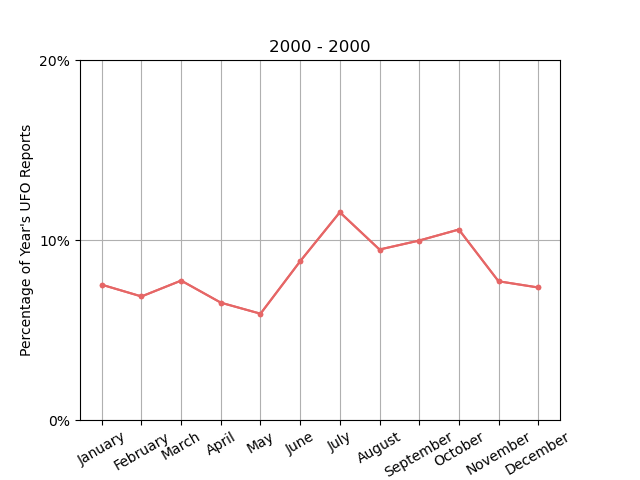

In [29]:
fig_3 = plt.figure()
ax = fig_3.add_axes([0.125, 0.125, 0.75, 0.75])

# Scaling
ax.set_ylim(0, 0.2)

# Ticks
ax.set_yticks(np.arange(0, 0.21, 0.1))
ax.set_yticklabels(['0%', '10%', '20%'])
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(month_names)
ax.tick_params(rotation = 30, axis = 'x')

# Labelling
ax.set_ylabel('Percentage of Year\'s UFO Reports')
ax.grid()

# These are all persistent variables for the plot_reports_by_month function 
# below.
indv_lines = []
minmax_lines = []

color_1 = (0.9, 0.4, 0.4, 1)
color_2 = (0.8, 0.8, 0.8, 1)
color_3 = (0.9, 0.4, 0.4, 0)

def plot_reports_by_month(frame):
    """Returns a list of artists which make up a frame of animation. This frame
    is generated according to the properties of the frame object.
    
    ----------------------------------------------------------------------------
    
    args:
        frame - dictionary containing relevant properties including the type of
        frame you want to generate and the data needed for that frame
        
    returns:
        iterable of matplotlib artists
    """
    # Phase 1 plots the individual month/year ratios for each year from 2000
    # to 2020. These lines accumulate on top of each other instead of replacing
    # or modifying the previous line.
    if frame.get('phase') == 1:
        # Update the title to reflect the year range being presented.
        ax.set_title('2000 - {}'.format(frame.get('year')))
        # Plot the month/year ratios for the current year and append that line
        # to the indv_lines list so that it can be recolored later.
        indv_lines.append(ax.plot(np.arange(0, 12), 
                          frame.get('positions'), 
                          color = color_1, 
                          marker = '.'))
        return indv_lines
    # Phase 2 plots two lines, one representing the minimum month/year ratio
    # for each month across every year, and the other representing the maximum.
    if frame.get('phase') == 2:
        # Plot the minimum and maximum ratio lines, and append them to the
        # minmax_lines list so they can be recolored later. They start out with
        # an alpha of 0 so they can be faded in in phase 4.
        minmax_lines.append(ax.plot(np.arange(12),
                            ratio_group['min'],
                            color = color_3,
                            marker = 'o'))
        minmax_lines.append(ax.plot(np.arange(12), 
                            ratio_group['max'], 
                            color = color_3,
                            marker = 'o'))
        return minmax_lines
    # Phase 3 fades the ratio lines for each year from pastel red to light grey.
    if frame.get('phase') == 3:
        # Linearly interpolate between the start and end color using the stage
        # property of this frame as a guide.
        indv_lines_stage = np.linspace(color_1, 
                                       color_2, 
                                       frame.get('stages'))[frame.get('stage')]
        # Update each line in the individual lines list with the new color.
        for line, in indv_lines:
            line.set_color(indv_lines_stage)
    # Phase 4 fades the minimum and maximum ratio lines in over the top of the
    # individual lines.
    if frame.get('phase') == 4:
        # Interpolate between the start and end color using the stage property
        # of this frame as a guide.
        minmax_lines_stage = np.linspace(color_3, 
                                         color_1, 
                                         frame.get('stages'))[frame.get('stage')]
        # Update both lines in the minmax_lines list with the cne wcolor.
        for line, in minmax_lines:
            line.set_color(minmax_lines_stage)

ani = FuncAnimation(fig = fig_3,
                    func = plot_reports_by_month,
                    frames = frames,
                    blit = True,
                    interval = 1000/30)
# The ipympl backend makes this notbook get very slow when this plot is rendered
# as interactive, so it needs to be closed.

#-------------------------------------------------------------------------------
path = 'Plots/3 - Reports Per Month 2000-2020.gif'
ani.save(path, fps = 60)
display.display(display.Image(path))

### Question 3.
Do more UFO sightings happen during day time or night time?

#### Day/Night Pie Chart

In [30]:
# Data Wrangling
day_night_counts = aliens[['day_night', 'summary']].groupby('day_night').count()

day_ratio = day_night_counts.loc['day']['summary']/aliens.shape[0]
night_ratio = day_night_counts.loc['night']['summary']/aliens.shape[0]

day_ratio = np.round(day_ratio, 2)
night_ratio = np.round(night_ratio, 2)

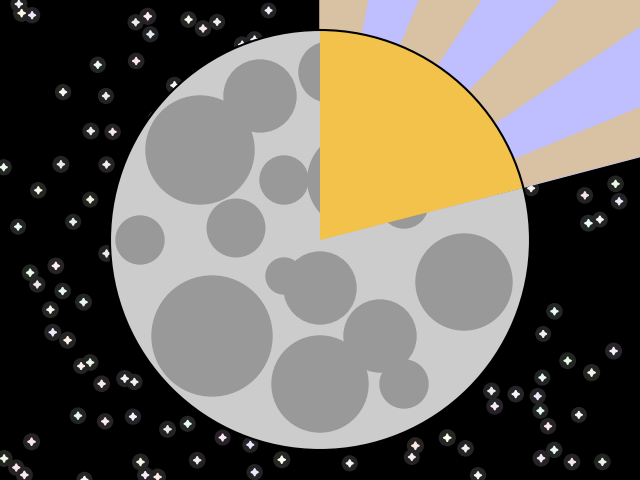

In [31]:
fig_5 = plt.figure()
ax = fig_5.add_axes([0, 0, 1, 1])
#
# Useful constants.
#
center = (0, 0)
radius = 1.75
xlim = 2.666666
ylim = 2
dn_palette = {
    'moon':(0.8, 0.8, 0.8),
    'mooncrater':(0.6, 0.6, 0.6),
    'sun':(0.95, 0.76, 0.29),
    'night':(0.31, 0, 0.55),
    'skyblue':(0.75, 0.75, 1),
    'sunray':(0.85 , 0.755, 0.645)
}

slices = ax.pie([day_ratio, night_ratio],
              startangle = 90,
              colors = [dn_palette.get('sun'), dn_palette.get('moon')],
              counterclock = False,
              center = center,
              radius = radius,
              normalize = False)
# Sun Z-order
slices[0][0] = slices[0][0].set_zorder(-2)
# Moon Z-order
slices[0][1] = slices[0][1].set_zorder(-4)
# Limits
ax.set_xlim(-xlim, xlim)
ax.set_ylim(-ylim, ylim)
ax.set_aspect('equal')
#
# Pie Border
#
border = ptchs.Circle(center, 
                      radius, 
                      fill=False, 
                      edgecolor="k", 
                      linewidth=1.5, 
                      antialiased = True,
                      zorder = -1)
ax.add_patch(border)
#
# Moon
#
class Crater:
    """This class generates a circle patch which can be added to a plot. These
    patches are meant to represent craters on the moon.
    """
    def __init__(self,
                 center, 
                 radius, 
                 color = dn_palette.get('mooncrater')):
        """args:
            center - tuple containing the xy coords for the center of the crater
            radius - float which sets the radius of the crater
        optional args:
            color - either name of color or iterable containing rgb(a) values
                defaults to mooncrater color in dn_palette
        """
        self.center = center
        self.radius = radius
        self.color = color
        
    def generate(self):
        """ Use this to get the circle patch after instatiating the crater.
        
        ------------------------------------------------------------------------
    
        returns:
            a circle patch made using the provided properties
        """
        return ptchs.Circle(xy = crater.center,
                            radius = crater.radius,
                            color = crater.color,
                            zorder = -3)
# Crater positions and sizes.
craters = [
    Crater((-1.5, 0), 0.2),
    Crater((-1, 0.75), 0.45),
    Crater((-0.9, -0.8), 0.5),
    Crater((-0.5, 1.2), 0.3),
    Crater((-0.3, -0.3), 0.15),
    Crater((-0.7, 0.1), 0.24),
    Crater((-0.3, 0.5), 0.2),
    Crater((0.3, 0.5), 0.4),
    Crater((0, -0.4), 0.3),
    Crater((0.7, -1.2), 0.2),
    Crater((0.3, 0.5), 0.4),
    Crater((0.5, -0.8), 0.3),
    Crater((0.7, 0.3), 0.2),
    Crater((1.2, -0.35), 0.4),
    Crater((0, -1.2), 0.4),
    Crater((0.075, 1.4), 0.25)
]
# Add each crater to the axes object.
for crater in craters:
    circle = crater.generate()
    ax.add_patch(circle)
#
# Night/Day Background
#
# Set the figure color
fig_5.patch.set_facecolor('k')
# Make a polygon with complimentary shape to the pie chart for the sunny sky.
verts = [(0, 0),
         (0, ylim),
         (xlim, ylim),
         (xlim, 0.7)]
sky = ptchs.Polygon(xy = verts,
                          closed = True,
                          color = dn_palette.get('skyblue'),
                          zorder = -7)
ax.add_patch(sky)
#
# Stars
#
class Star:
    """This class generates a polygon patch resembling a star. The star has four
    points, one in each cardinal direction. The vertices at the points are
    referred to by this class as "major vertices". Of course there are "minor
    vertices" as well, which represent the corners in between these vertices.
    """
    def __init__(self,
                 center = (0, 0),
                 major_length = 0.03,
                 minor_length = 0.01,
                 major_noise = 0.003,
                 minor_noise = 0.001):
        """optional args:
            center - tuple containing the xy coords for the center of the star
                defaults to (0, 0)
            major_length - major points' distance from the center
                defaults to 0.03
            minor_length - minor points' distance from the center
                defaults to 0.01
            major_noise - max amount of randomly generate length to add to the
            major length
                defaults to 0.003
            major_noise - max amount of randomly generate length to add to the
            minor length
                defaults to 0.001
        
        """
        self.x = center[0]
        self.y = center[1]
        # Add noise to the major and minor points.
        self.major_length = major_length + np.random.random() * major_noise
        self.minor_length = minor_length + np.random.random() * minor_noise
        # The base color for each star is (0.9, 0.9, 0.9).
        # Then a distinct random value between 0 and 0.1 is added to each value.
        self.color = np.full(3, 0.9) + np.random.random(3) * 0.1
        
    def generate_star(self):
        """Creates a polygon patch resembling a star, the properties of which
        are set when initializing the object.
        
        ------------------------------------------------------------------------
    
        returns:
            polygon patch that resembles a star
        """
        # Multiply the length of the major and minor points by the provided
        # lengths.
        majors = np.array([
            (0, 1),
            (1, 0),
            (0, -1),
            (-1, 0)
        ]) * self.major_length
        minors = np.array([
            (1, 1),
            (1, -1),
            (-1, -1),
            (-1, 1)
        ]) * self.minor_length
        # Interlace the major and minor points into a single list.
        verts = np.array([0, 0])
        for major, minor in zip(majors, minors):
            verts = np.vstack([verts, [major[0], major[1]]])
            verts = np.vstack([verts, [minor[0], minor[1]]])
        verts = verts[1:]
        # Center the points around the provided center coordinates.
        verts[:, 0] += self.x
        verts[:, 1] += self.y
        # Return a polygon made using the vertex list.
        star = ptchs.Polygon(xy = verts,
                             color = self.color,
                             zorder = -8)
        return star
    
    def generate_halo(self):
        """The halo is an optional extra patch, the radius of which exceeds the
        star's major length. The color of the halo is 15% as bright as the
        star's color, in order to give the appearance of translucency.
        
        ------------------------------------------------------------------------
    
        returns:
            circle patch which will be rendered behind the star
        """
        return ptchs.Circle((self.x, self.y),
                            color = self.color * 0.15,
                            radius = self.major_length * 2,
                            zorder = -9)
# Generate 100 stars with coordinates in the left half of the axis. The blue sky
# polygon is above the star layer so the stars won't overlap despite the odd 
# night sky boundary.
stars = []
for i in np.arange(200):
    stars.append(Star((np.random.random() * -(xlim * 2) + xlim, 
                       np.random.random() * -(ylim * 2) + ylim)))
# Add stars to the axes obejct.
for star in stars:
    ax.add_patch(star.generate_halo())
    ax.add_patch(star.generate_star())
#
# Sunrays
#
# Each ray is a triangle with a point at 0, so each of these tuples defines the 
# two other points.
rays = [
#   [(  x  ,  y  )  (  x  ,  y  )],
    [(    0,    4), ( 0.78, 3.92)],
    [( 1.53, 3.69), ( 2.22, 3.32)],
    [( 2.83, 2.83), ( 3.32, 2.22)],
    [( 3.70, 1.53), ( xlim, 0.7)]
]
# Add a triangle to the axes object with provided points for each tuple in the 
# rays list.
for ray in rays:
    verts = [(0, 0)]
    verts.extend(ray)
    ax.add_patch(ptchs.Polygon(verts,
                               color = dn_palette.get('sunray'),
                               zorder = -5))
#
#
# - Z-Order Cheatsheet -
#   0 ~ Text
#  -1 ~ Border
#  -2 ~ Sun
#  -3 ~ Craters
#  -4 ~ Moon
#  -5 ~ Sun Rays
#  -6 ~ Clouds (Not Used)
#  -7 ~ Blue Sky
#  -8 ~ Stars
#  -9 ~ Star Halos
# -10 ~ Night Sky/Figure
#
#

#-------------------------------------------------------------------------------
save_and_show('Plots/4 - Day v Night Sightings.png', fig_5)

#### Cumulative UFO Reports Per Hour

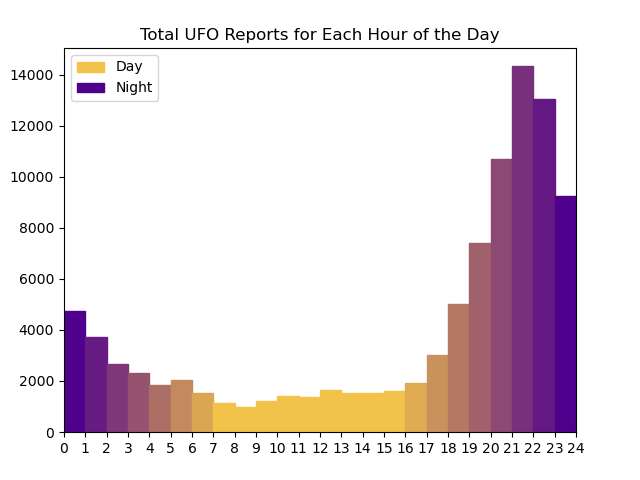

In [32]:
fig_6 = plt.figure()
ax = fig_6.add_axes([0.1, 0.1, .8, .8])

# Head (0 - 7) gradient colors.
head = list(np.linspace(dn_palette.get('night'),
                        dn_palette.get('sun'),
                        num = 8))
# Body (8 - 15) solid color.
body = np.full((7, 3), 
               dn_palette.get('sun'))
# Tail (16 - 24) gradient colors.
tail = list(np.linspace(dn_palette.get('sun'),
                        dn_palette.get('night'),
                        num = 9))
# Combine colors sequences into single list.
colors = []
colors.extend(head)
colors.extend(body)
colors.extend(tail)

bars = ax.hist(aliens.hour, bins = np.arange(25))

# Set the color of each bar according to the sequence above.
for i, bar in enumerate(bars[2]):
    bar.set_color(colors[i])
# Ticks
ax.set_xticks(np.arange(25))
ax.set_xlim(0, 24)
# Labelling
ax.set_title('Total UFO Reports for Each Hour of the Day');
handles = [ptchs.Patch(color = dn_palette.get('sun')),
           ptchs.Patch(color = dn_palette.get('night'))]
ax.legend(handles, ['Day', 'Night']);

#-------------------------------------------------------------------------------
save_and_show('Plots/5 - Reports By Hour.png', fig_6)

### Question 4.
How has the amount of UFO sightings per year changed over time?

#### UFO Reports Per Year Trend

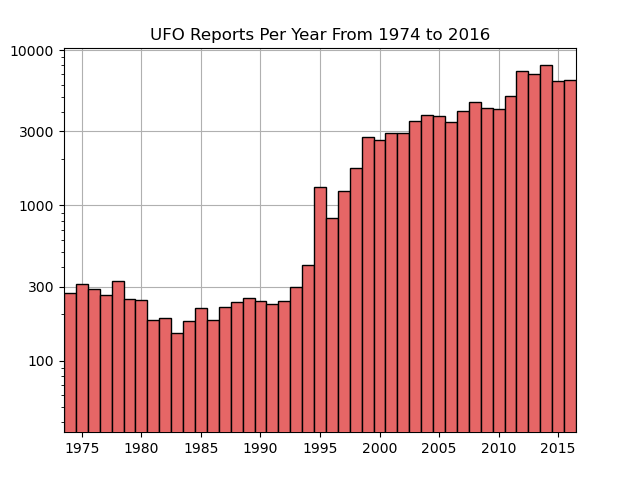

In [33]:
fig_3 = plt.figure()
ax = fig_3.add_axes([0.1, 0.1, 0.8, 0.8])

ax.hist(aliens.year, 
        bins = np.arange(1956, 2018, 1),
        color = (0.9, 0.4, 0.4),
        align = 'left',
        edgecolor = 'black',
        zorder = 5)

# Scaling
ax.set_yscale('log')
ax.set_xlim(1973.5, 2020.5)

#Ticks
ax.set_xticks(np.arange(1975, 2017, 5))
ax.set_yticks([100, 300, 1000, 3000, 10000])
ax.set_yticklabels([100, 300, 1000, 3000, 10000])

# Labelling
ax.grid(zorder = 0)
ax.set_title('UFO Reports Per Year From 1974 to 2020');

#-------------------------------------------------------------------------------
save_and_show('Plots/6 - Reports Per Year.png', fig_3)

### Question 5.
What state has the most UFO reports per capita?

#### UFO Reports Per Capita

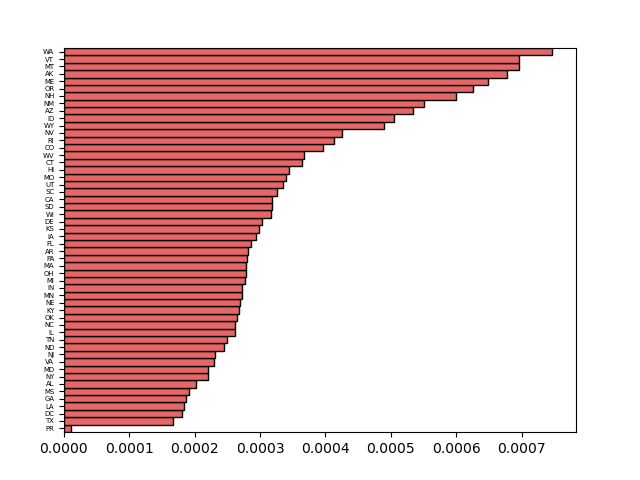

In [34]:
fig_7 = plt.figure()
ax = fig_7.add_axes([0.1, 0.1, 0.8, 0.8])

bars = ax.barh(states.index,
               states.reports_per_capita,
               height = 1,
               edgecolor = 'black',
               color = (0.9, 0.4, 0.4))

# Scaling
ax.set_ylim([-0.5, 51.5])

# Ticks
ax.tick_params(labelsize = 5, axis = 'y');

#-------------------------------------------------------------------------------
save_and_show('Plots/7 - Reports Per Capita Per State.png', fig_7)